# Title:

Analyzing difference in hate speech between 2016 and 2020 Presedential election terms

## State the problem:

Analyzing hate speech patterns during 2016 and 2020 presidential term and comparision of hate
speech trends between these two election cycles.

## Description of topic of the project:

“The Trump Effect” is a term coined after an increase in bullying in school post the 2016 elections
but has expanded to include religious and racial hate speech/bullying by adults during his
presidential term. We want to perform a comparison of hate speech trends seen in the 2016 and
2020 elections.

### Research questions:

1. What theme of hate speech are more prevalent in the two election periods?
2. Which election term saw a greater rise in hate speech?

## Phase 1 Credit Listing

Data Loading 2016: Meghana Parab


Data Loading 2020: Malvika Mohan


EDA on loaded data: Julius Coleman

## Phase 2 Credit Listing

Exploratory Data Visualizations and Training Data Preprocessing : Malvika Mohan

Feature Extraction and Model Training : Meghana Parab

Model Comparison and Classification on the two Election Dataset : Julius Coleman

# Import Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,TweetTokenizer,sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from empath import Empath 
from collections import defaultdict 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import datetime
import random

# Importing and Altering Datasets

In [2]:
# Set display to max width
pd.set_option('display.max_colwidth', None)

## Election 2016

In [3]:
# Read election_2016 csv file and store it in pandas dataframe
election_2016 = pd.read_csv('election_2016.csv', index_col=0)

In [4]:
# Print number of rows and columns in election_2016 dataframe
print(election_2016.shape)

(157612, 3)


In [5]:
# Print data types of each of the columns 
print(election_2016.dtypes)

Tweet_content         object
Tweet_ids              int64
Tweet_date_created    object
dtype: object


In [6]:
# View first several rows from election_2016 dataframe
election_2016.head()

,Tweet_content,Tweet_ids,Tweet_date_created
0,Share ideas on cleaning up the Willamette at Portland Harbor Community Cafe tonight! https://t.co/Kng9mnEi8h,621834240414449664,2015-07-17 00:10:10
1,"RT @gene_wang: Three schools could host @american_FB title game. #NavyFootball is one of them, but it's complicated. My story: https://t.co…",802273369693548544,2016-11-25 22:10:51
2,#Syphilis can also spread from #mom to #baby via the placenta during #pregnancy or delivery https://t.co/XWAV6lS0tT #Health4Her #Parenting,786272305647190016,2016-10-12 18:28:20
3,We won't achieve the #SDGs through resources alone (by factor of 10); we need innovation &amp; partnerships - @annmei at @BrookingsInst #GPW2016,707315802551263234,2016-03-08 21:23:23
4,How does a college application form differ for international students looking to study in the U.S.? https://t.co/kMYcnKCQwS,646752283255021568,2015-09-23 18:25:35


In [7]:
# Rename column names
election_2016.columns = ['text', 'id', 'created_at']

In [8]:
# Convert 'created_at' column to datetime
election_2016['created_at'] = pd.to_datetime(election_2016['created_at'])

In [9]:
##Filtering out dates before 2016 in corpus 
election_2016 = (election_2016[election_2016['created_at']>='2016-01-01']).reset_index(drop=True)

In [10]:
election_2016.shape

(87784, 3)

In [11]:
election_2016 = election_2016.sample(80000, random_state=0).reset_index(drop=True)

In [12]:
election_2016.shape

(80000, 3)

In [13]:
# View first several rows from election_2016 dataframe after being altered
election_2016.head()

,text,id,created_at
0,"The contiguous U.S. cold spot this morning was -4F at Monte Vista, CO. #mewx #cowx",803349568813404160,2016-11-28 21:27:17
1,"Milder today, then snow and colder air moving from west to east tonight into Monday. https://t.co/mppq8s5DJe",696287604816240641,2016-02-07 11:01:16
2,@AldoAvina Yes! \n\nInfo about PSLF: https://t.co/4s8c99LDFA \n\nInfo about our income-based repayment plans: https://t.co/xhIb16NYsX,806195036849315840,2016-12-06 17:54:09
3,Yesterdays high temp in MT was 71 at Hysham. This mornings low was 21 at Dunkirk 19nne. #mtwx,795669675103371264,2016-11-07 16:50:08
4,"RT @WhiteHouse: ""The ideas of ancient Greece helped inspire America's Founding Fathers as they reached for democracy."" —@POTUS",798537212363214848,2016-11-15 14:44:42


## Election 2020

In [14]:
# Read election_2020 csv file and store it in pandas dataframe
election_2020 = pd.read_csv('Elections_2020.csv', index_col=0)

In [15]:
# Print number of rows and columns in election_2020 dataframe
print(election_2020.shape)

(163445, 3)


In [16]:
# Print data types of each of the columns 
print(election_2020.dtypes)

id             int64
created_at    object
text          object
dtype: object


In [17]:
# View first several rows from election_2020 dataframe
election_2020.head()

,id,created_at,text
0,1200957690937106433,Sun Dec 01 02:00:00 +0000 2019,RT @Condor_Law: New report released today shows that @JoeBiden stole $140million from the federal treasury—transferred the money to Rosemon…
1,1200942590624960517,Sun Dec 01 01:00:00 +0000 2019,"RT @TimOBrien: Trump’s salary is $400,000 annually.\n\nThe Trump family has made tens of millions of dollars on their DC hotel.\n\nThe governme…"
2,1200942590864056320,Sun Dec 01 01:00:00 +0000 2019,"RT @LevineJonathan: During his ""No Malarkey!"" tour in Council Bluffs @JoeBiden leaned over and BIT his wife @DrBiden's finger https://t.co/…"
3,1200927489792626688,Sun Dec 01 00:00:00 +0000 2019,"@senatemajldr @realDonaldTrump Yeah, not like you stalled anything before!"
4,1200957688798236672,Sun Dec 01 02:00:00 +0000 2019,@SexCounseling @realDonaldTrump You're right that Republicans and trump are doing a good job destroying this country


In [18]:
# Reorder columns
election_2020 = election_2020[['text', 'id', 'created_at']]

In [19]:
# Convert 'created_at' column to datetime
election_2020['created_at'] = pd.to_datetime(election_2020['created_at'])

In [20]:
election_2020 = election_2020.sample(80000, random_state=0).reset_index(drop=True)

In [21]:
election_2020.shape

(80000, 3)

In [22]:
# View first several rows from election_2016 dataframe after being altered
election_2020.head()

,text,id,created_at
0,RT @amyklobuchar: Today Judge Coney Barrett would not say whether voter intimidation is illegal. \n\nJust to be clear: voter intimidation IS…,1316197007808233474,2020-10-14 01:59:55+00:00
1,RT @MalcolmNance: Since @realDonaldTrump is theoretically President I’m pretty sure these are #TrumpRiots &amp; #TrumpViolence,1300116046221697024,2020-08-30 16:59:55+00:00
2,@matteosalvinimi @realDonaldTrump davvero pochini in Piazza....se non li paghi non vengono!,1279671336474992641,2020-07-05 06:59:56+00:00
3,"RT @papscun: .@politico is reporting that @AmericanU President @SylviaBurwell is being considered for HHS Secretary, a role she previously…",1335101576436994048,2020-12-05 05:59:55+00:00
4,"RT @gtconway3d: For 70 days, @realDonaldTrump dithered and deceived. And lives were lost because of his lies.\n\n#70days #clustertrump",1246814856767893504,2020-04-05 15:00:01+00:00


# Cleaning Data

## Clean Text

In [23]:
# Create function that cleans tweets
def clean_tweets(text):
    text = text.lower() # Convert all text to lowercase
    text = re.sub(r'http\S+', '',text) # Remove urls
    text = re.sub("rt @[\w]*:",'',text) # Remove retweet tag
    text = re.sub("@[\w]*",'',text) # Remove mentions
    text = re.sub("\n",' ',text) # Remove instances of "\n"
    text = re.sub("&amp",'',text) # Remove instances of "&amp"
    text = re.sub(r'[^\w\s]','',text) # Remove punctuations
    text = re.sub('\d+', '', text) # Remove digits
    text = re.sub('[^A-Za-z .-]+', '', text) #Remove other special characters
    text = text.replace('_','')
    text = text.strip("  ") # Remove extra whitespace
    return text

In [24]:
# Clean tweets in election_2016 dataframe using clean_tweets function
election_2016['text'] = election_2016['text'].apply(lambda x: clean_tweets(x))

In [25]:
# Show examples of cleaned tweets
election_2016.iloc[:,0:1].head()

,text
0,the contiguous us cold spot this morning was f at monte vista co mewx cowx
1,milder today then snow and colder air moving from west to east tonight into monday
2,yes info about pslf info about our incomebased repayment plans
3,yesterdays high temp in mt was at hysham this mornings low was at dunkirk nne mtwx
4,the ideas of ancient greece helped inspire americas founding fathers as they reached for democracy


In [26]:
# Clean tweets in election_2020 dataframe using clean_text function
election_2020['text'] = election_2020['text'].apply(lambda x: clean_tweets(x))

In [27]:
# Show examples of cleaned tweets
election_2020.iloc[:,0:1].head()

,text
0,today judge coney barrett would not say whether voter intimidation is illegal just to be clear voter intimidation is
1,since is theoretically president im pretty sure these are trumpriots trumpviolence
2,davvero pochini in piazzase non li paghi non vengono
3,is reporting that president is being considered for hhs secretary a role she previously
4,for days dithered and deceived and lives were lost because of his lies days clustertrump


## Remove Stop Words

In [28]:
# Get english stopwords from nltk package
stopword = nltk.corpus.stopwords.words('english')

In [29]:
election_2016['text'] = election_2016['text'].apply(lambda x :' '.join([word for word in x.split() if word not in stopword]) )
election_2016.iloc[:,0:1].head()

,text
0,contiguous us cold spot morning f monte vista co mewx cowx
1,milder today snow colder air moving west east tonight monday
2,yes info pslf info incomebased repayment plans
3,yesterdays high temp mt hysham mornings low dunkirk nne mtwx
4,ideas ancient greece helped inspire americas founding fathers reached democracy


In [30]:
election_2020['text'] = election_2020['text'].apply(lambda x :' '.join([word for word in x.split() if word not in stopword]) )
election_2020.iloc[:,0:1].head()

,text
0,today judge coney barrett would say whether voter intimidation illegal clear voter intimidation
1,since theoretically president im pretty sure trumpriots trumpviolence
2,davvero pochini piazzase non li paghi non vengono
3,reporting president considered hhs secretary role previously
4,days dithered deceived lives lost lies days clustertrump


## Lemmitization

In [31]:
lemmatizer = WordNetLemmatizer()
election_2016['text'] = election_2016['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
election_2016.iloc[:,0:1].head()

,text
0,contiguous u cold spot morning f monte vista co mewx cowx
1,milder today snow colder air moving west east tonight monday
2,yes info pslf info incomebased repayment plan
3,yesterday high temp mt hysham morning low dunkirk nne mtwx
4,idea ancient greece helped inspire america founding father reached democracy


In [32]:
election_2020['text'] = election_2020['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
election_2020.iloc[:,0:1].head()

,text
0,today judge coney barrett would say whether voter intimidation illegal clear voter intimidation
1,since theoretically president im pretty sure trumpriots trumpviolence
2,davvero pochini piazzase non li paghi non vengono
3,reporting president considered hhs secretary role previously
4,day dithered deceived life lost lie day clustertrump


## Stemming

In [33]:
stemmer = PorterStemmer()
election_2016['text'] = election_2016['text'].apply(lambda x : ' '.join([stemmer.stem(word) for word in x.split()]))
election_2016.iloc[:,0:1].head()

,text
0,contigu u cold spot morn f mont vista co mewx cowx
1,milder today snow colder air move west east tonight monday
2,ye info pslf info incomebas repay plan
3,yesterday high temp mt hysham morn low dunkirk nne mtwx
4,idea ancient greec help inspir america found father reach democraci


In [34]:
election_2020['text'] = election_2020['text'].apply(lambda x : ' '.join([stemmer.stem(word) for word in x.split()]))
election_2020.iloc[:,0:1].head()

,text
0,today judg coney barrett would say whether voter intimid illeg clear voter intimid
1,sinc theoret presid im pretti sure trumpriot trumpviol
2,davvero pochini piazzas non li paghi non vengono
3,report presid consid hh secretari role previous
4,day dither deceiv life lost lie day clustertrump


## Tokenization

In [35]:
# Tokenize text in election_2016 dataframe using TweetTokenizer
election_2016['text_tokens'] = election_2016['text'].apply(lambda x: TweetTokenizer().tokenize(x))

In [36]:
# Show tokenized tweets from election_2016 dataframe
election_2016[['text','text_tokens']].head()

,text,text_tokens
0,contigu u cold spot morn f mont vista co mewx cowx,"[contigu, u, cold, spot, morn, f, mont, vista, co, mewx, cowx]"
1,milder today snow colder air move west east tonight monday,"[milder, today, snow, colder, air, move, west, east, tonight, monday]"
2,ye info pslf info incomebas repay plan,"[ye, info, pslf, info, incomebas, repay, plan]"
3,yesterday high temp mt hysham morn low dunkirk nne mtwx,"[yesterday, high, temp, mt, hysham, morn, low, dunkirk, nne, mtwx]"
4,idea ancient greec help inspir america found father reach democraci,"[idea, ancient, greec, help, inspir, america, found, father, reach, democraci]"


In [37]:
# Tokenize text in election_2020 dataframe using TweetTokenizer
election_2020['text_tokens'] = election_2020['text'].apply(lambda x: TweetTokenizer().tokenize(x))

In [38]:
# Show tokenized tweets from election_2020 dataframe
election_2020[['text','text_tokens']].head()

,text,text_tokens
0,today judg coney barrett would say whether voter intimid illeg clear voter intimid,"[today, judg, coney, barrett, would, say, whether, voter, intimid, illeg, clear, voter, intimid]"
1,sinc theoret presid im pretti sure trumpriot trumpviol,"[sinc, theoret, presid, im, pretti, sure, trumpriot, trumpviol]"
2,davvero pochini piazzas non li paghi non vengono,"[davvero, pochini, piazzas, non, li, paghi, non, vengono]"
3,report presid consid hh secretari role previous,"[report, presid, consid, hh, secretari, role, previous]"
4,day dither deceiv life lost lie day clustertrump,"[day, dither, deceiv, life, lost, lie, day, clustertrump]"


# Visualizations

## WordCloud

In [39]:
# Add all words in 'text_tokens' from election_2016 dataframe into one list
all_words_list_2016 = election_2016['text_tokens'].apply(pd.Series).stack().tolist()

# Combine all words from list into single string
all_words_2016 = ' '.join([str(elem) for elem in all_words_list_2016])

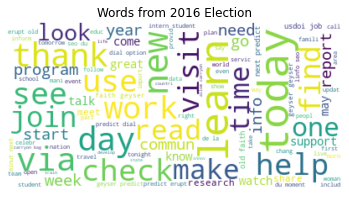

Total Count of Words: 4574685


In [40]:
# Create wordcloud of all words in election_2016 dataframe after being cleaned, tokenized, and having stop words removed
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_words_2016)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Words from 2016 Election")
plt.axis("off")
plt.show()

# Print total amount of words used for word cloud
print ("Total Count of Words: {}".format(len(all_words_2016)))

In [41]:
# Add all words in 'text_tokens' from election_2020 dataframe into one list
all_words_list_2020 = election_2020['text_tokens'].apply(pd.Series).stack().tolist()

# Combine all words from list into single string
all_words_2020 = ' '.join([str(elem) for elem in all_words_list_2020])

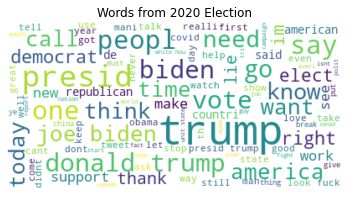

Total Count of Words: 3697419


In [42]:
# Create wordcloud of all words in election_2020 dataframe after being cleaned, tokenized, and having stop words removed
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_words_2020)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Words from 2020 Election")
plt.axis("off")
plt.show()

# Print total amount of words used for word cloud
print ("Total Count of Words: {}".format(len(all_words_2020)))

# Phase 2

### Sentiment Analysis using Vader

In [43]:
vader_sentiment_2016 =[]
count=0
analyzer = SentimentIntensityAnalyzer()
for tweet in election_2016['text']:
    sentiment_score=analyzer.polarity_scores(tweet)#Calculating the vader compound sentiment score of each tweet
    vader_sentiment_2016.append(sentiment_score) #adding the sentiment score of the tweet to a list for later analysis
    count+=1
    if count<=10:
        print(tweet,sentiment_score) #printing the first 10 tweets and their vader sentiment score

contigu u cold spot morn f mont vista co mewx cowx {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
milder today snow colder air move west east tonight monday {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ye info pslf info incomebas repay plan {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
yesterday high temp mt hysham morn low dunkirk nne mtwx {'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'compound': -0.2732}
idea ancient greec help inspir america found father reach democraci {'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.4215}
season influenza circul pattern project flu armysafeti healthher mede {'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'compound': -0.3818}
imper citizenshipth idea hard work peopl love countri chang {'neg': 0.111, 'neu': 0.556, 'pos': 0.333, 'compound': 0.5859}
misclassif myth doesnt matter classifi independ contractor employe true {'neg': 0.099, 'neu': 0.644, 'pos': 0.257, 'compound': 0.4071}
check awesom carv pumpkin base pagefright pattern do

#### Finding propotion of tweets with negative sentiment in the corpus

In [44]:
#Calculating the propotion of tweets containing negative sentiment in our 2016 election corpus
negative_sentiment_count =0
for sentiment in vader_sentiment_2016:
    if -0.05<= sentiment['compound']:
        negative_sentiment_count+=1

        
    

In [45]:
print("propotion of negative sentiment tweets in the 2016 election corpus is "+ str(((negative_sentiment_count)/len(vader_sentiment_2016))*100)+"%")


propotion of negative sentiment tweets in the 2016 election corpus is 89.63250000000001%


In [46]:
vader_sentiment_2020 =[]
count=0
analyzer = SentimentIntensityAnalyzer()
for tweet in election_2020['text']:
    sentiment_score=analyzer.polarity_scores(tweet)#Calculating the vader compound sentiment score of each tweet
    vader_sentiment_2020.append(sentiment_score) #adding the sentiment score of the tweet to a list for later analysis
    count+=1
    if count<=10:
        print(tweet,sentiment_score) #printing the first 10 tweets and their vader sentiment score

today judg coney barrett would say whether voter intimid illeg clear voter intimid {'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'compound': 0.3818}
sinc theoret presid im pretti sure trumpriot trumpviol {'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.3182}
davvero pochini piazzas non li paghi non vengono {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
report presid consid hh secretari role previous {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
day dither deceiv life lost lie day clustertrump {'neg': 0.247, 'neu': 0.753, 'pos': 0.0, 'compound': -0.3182}
support decis trump made nation guard move again {'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'compound': 0.4019}
presid trump tri rewrit histori come china covid fact dont back toni blin {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
believ found trump covid dia newsnot wh {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
dont know pull would counter program next week speak downtown portland {'neg': 0.0, 'neu': 1

In [47]:
#Calculating the propotion of tweets containing negative sentiment in our 2020 election corpus
negative_sentiment_count =0
for sentiment in vader_sentiment_2020:
    if -0.05<= sentiment['compound']:
        negative_sentiment_count+=1 


In [48]:
print("propotion of negative sentiment tweets in the 2020 election corpus is "+ str(((negative_sentiment_count)/len(vader_sentiment_2020))*100)+"%")


propotion of negative sentiment tweets in the 2020 election corpus is 73.86749999999999%


**Inference** Based on the results obtained we see that 85% of our 2016 election corpus is comprised of negative sentiment tweets and approx. 67% of our 2020 election corpus consists of negative sentiment tweets. 

### EDA 1 : How does the sentiment of tweets across the two election periods vary with time?

**Inference** On plotting the rolling average sentiment per day across the 2016 and 2020 election corpus, we see that overall the sentiment of tweets during the 2016 election was neutral. However, for the 2020 election corpus, there are spikes of negative sentiment  tweets on March 2020. We also see a gap in the 2020 election graph for October 2020, indicating that we may not have many tweets for the month in our dataset.

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
#Creating a dataframe with text, polarity and tweet created time to plot
dataset_plot = pd.DataFrame()
dataset_plot['text_2016'] = election_2016['text'] 
dataset_plot['timestamp_2016'] = election_2016['created_at'] 
dataset_plot['text_2020'] = election_2020['text'] 
dataset_plot['timestamp_2020'] = election_2020['created_at'] 

# Using vader to identify polarity of corpus
dataset_plot["sentiment_polarity_2016"] = dataset_plot.apply(lambda x: analyzer.polarity_scores(x["text_2016"])['compound'], axis=1)
dataset_plot

# Using vader to identify polarity of corpus
dataset_plot["sentiment_polarity_2020"] = dataset_plot.apply(lambda x: analyzer.polarity_scores(x["text_2020"])['compound'], axis=1)


In [51]:
#Creating a column for rolling average of polarity of tweets per day over time
dataset_plot.reset_index(drop=True)
dataset_plot.sort_values(by='timestamp_2016', inplace=True)
dataset_plot.index= dataset_plot['timestamp_2016']
dataset_plot['rolling_avg_2016'] = dataset_plot['sentiment_polarity_2016'].rolling('1d').mean()

(-1.0, 1.0)

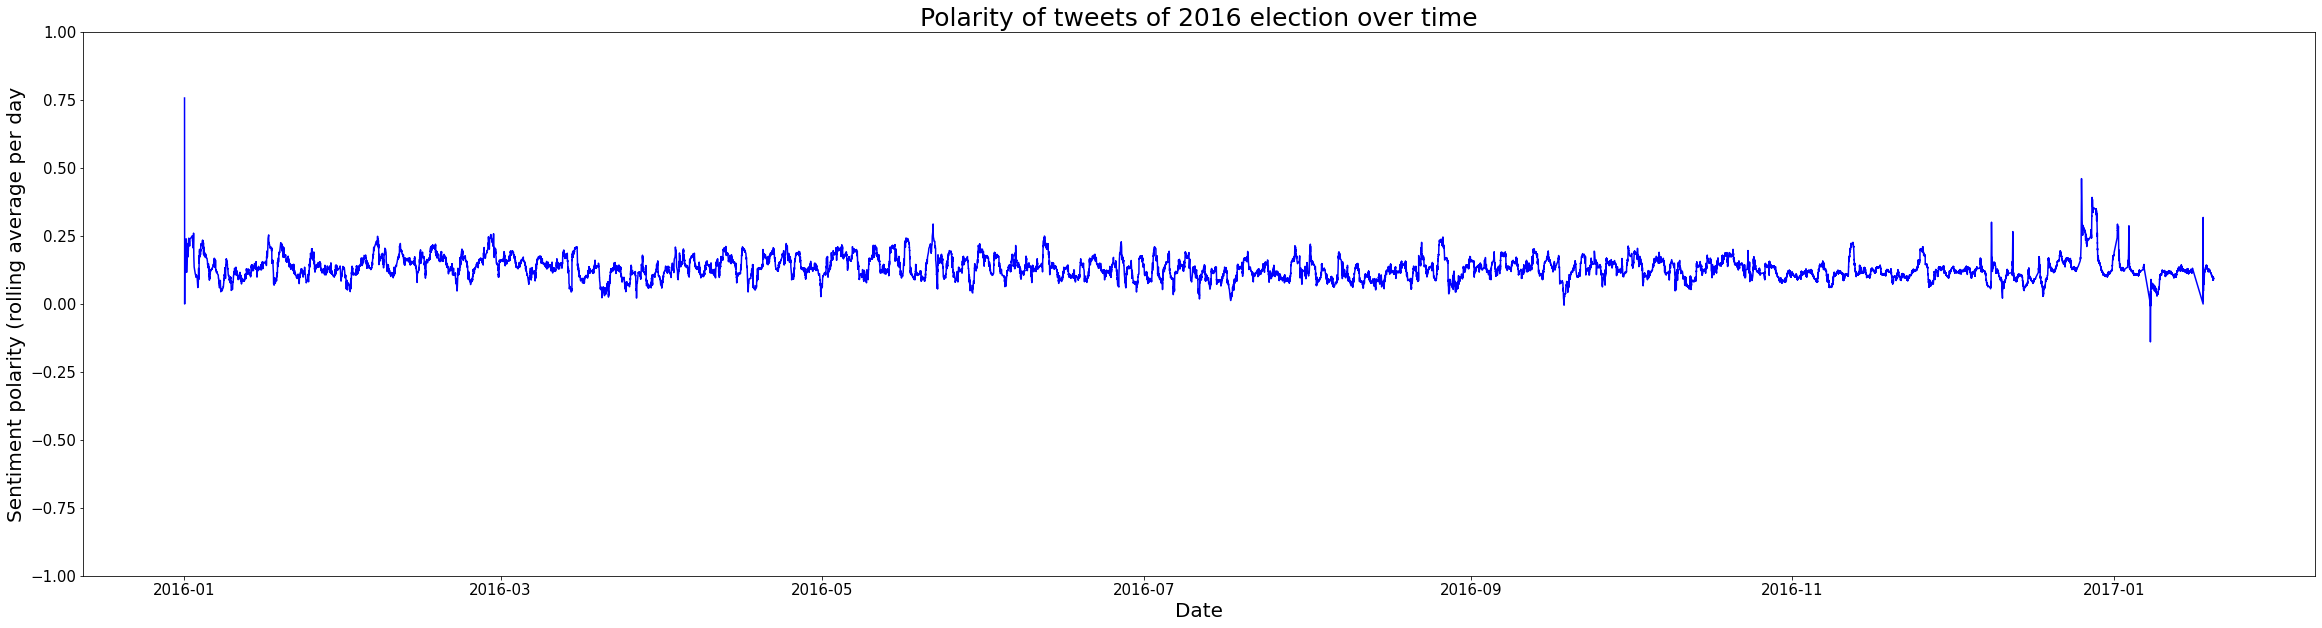

In [52]:
fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(111)
ax.plot(dataset_plot['timestamp_2016'],dataset_plot['rolling_avg_2016'], color ='b', label='Rolling Mean')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Sentiment polarity (rolling average per day', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.title('Polarity of tweets of 2016 election over time',fontdict={'fontsize':25})
ax.set_ylim([-1,1])

In [53]:
dataset_plot.reset_index(drop=True)
dataset_plot.sort_values(by='timestamp_2020', inplace=True)
dataset_plot.index= dataset_plot['timestamp_2020']
dataset_plot['rolling_avg_2020'] = dataset_plot['sentiment_polarity_2020'].rolling('1d').mean()

(-1.0, 1.0)

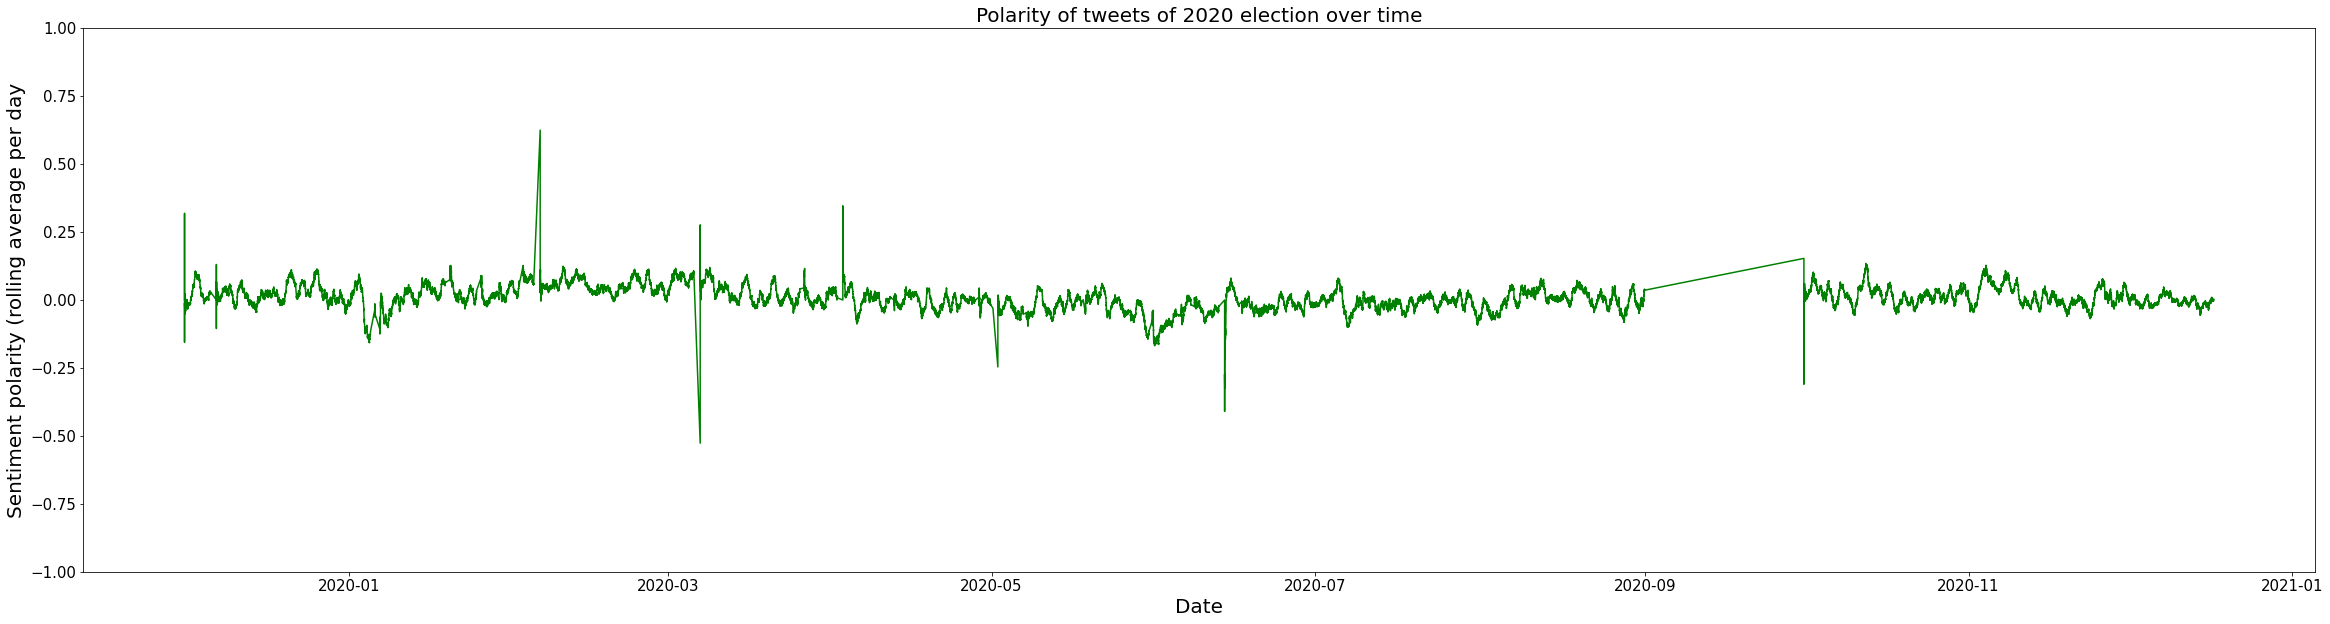

In [54]:
fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(111)
ax.plot(dataset_plot['timestamp_2020'],dataset_plot['rolling_avg_2020'], color ='g', label='Rolling Mean')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Sentiment polarity (rolling average per day', fontsize = 20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.title('Polarity of tweets of 2020 election over time',fontdict={'fontsize':20})
ax.set_ylim([-1,1])

### EDA 2 : What are the most common categories of tweets across the two election periods?

**Inference** : Using empath to find the categories that each tweet belongs to, we find the highest category count across all tweets. Based on the visualization obtained below, we see that the tweets from both election periods are majorly based on categories communication and speaking. However a majority of tweets from the 2020 category also show negative emotions, government and politics.

In [55]:
lexicon = Empath()

In [56]:
#Finding the categories of each tweet returning a dictionary containing the frequence of each category in all tweets
def get_categories(dataset): 
    catgeories_count = defaultdict(int)
    for tweet in dataset['text']:
        categ = lexicon.analyze(tweet)
        if categ:
            for key, value in categ.items():
                if value != 0:
                    catgeories_count[key]+=1
    return catgeories_count

In [57]:
catgeories_count_2016 = get_categories(election_2016)

Text(0.5, 1.0, 'Top 10 category count of tweets across 2016 election corpus')

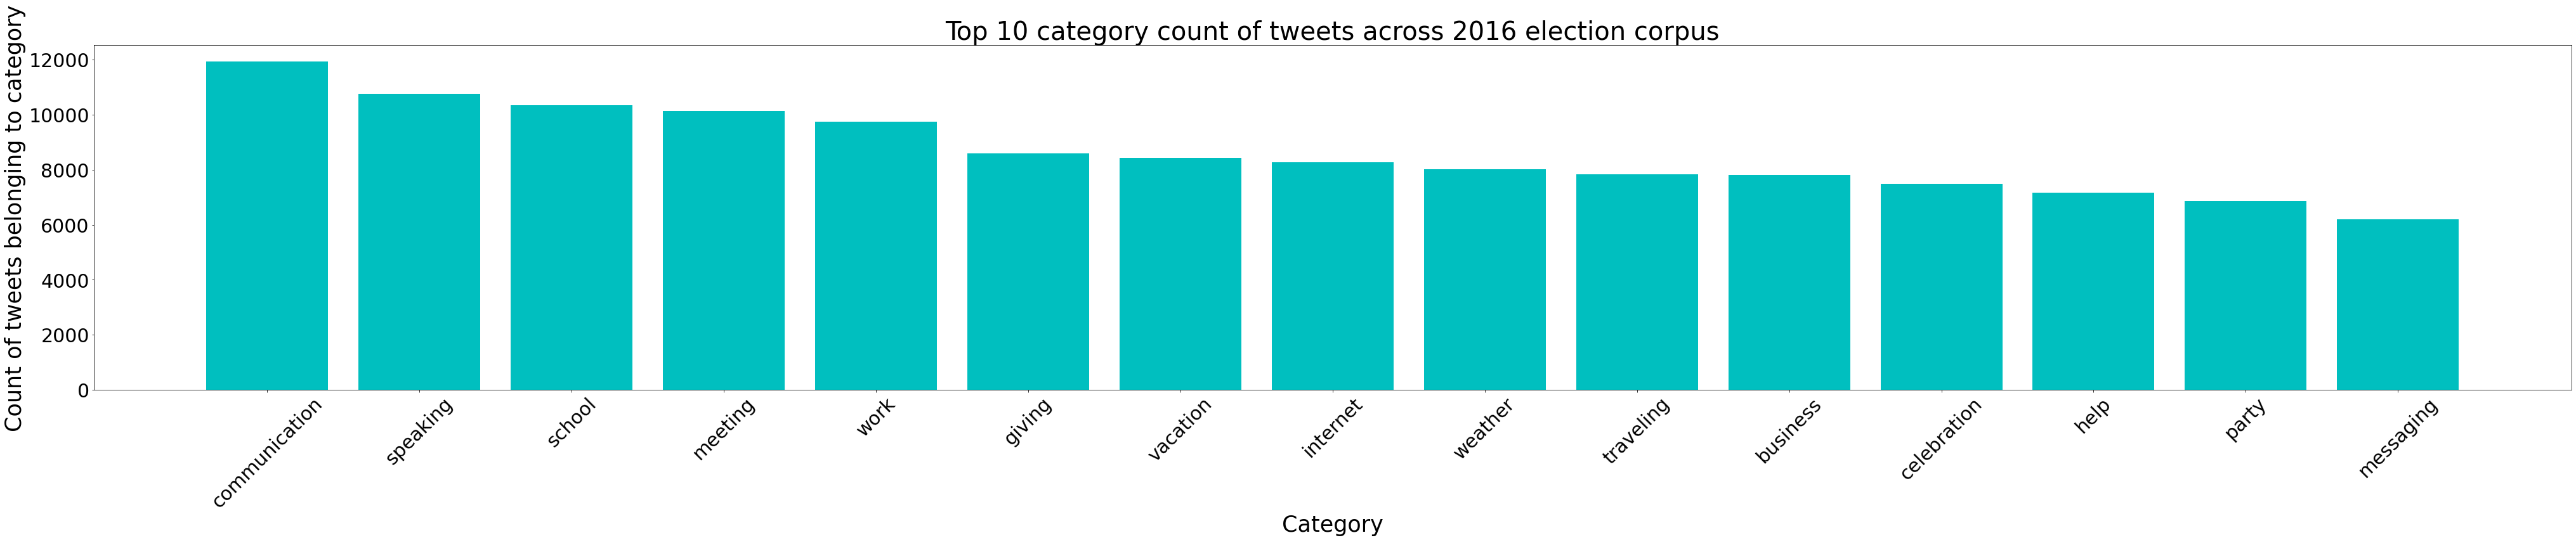

In [58]:
fig = plt.figure(figsize=(70,10))

top_10_categories = dict(sorted(catgeories_count_2016.items(), key=lambda x:x[1],reverse =True)[:15])
plt.bar(top_10_categories.keys(), top_10_categories.values(), color='c')
plt.xlabel('Category', fontsize = 35)
plt.ylabel('Count of tweets belonging to category', fontsize = 35)
plt.xticks(fontsize=30,rotation = (45))
plt.yticks(fontsize=30)
plt.title('Top 10 category count of tweets across 2016 election corpus',fontdict={'fontsize':40})


In [59]:
catgeories_count_2020 = get_categories(election_2020)

Text(0.5, 1.0, 'Top 10 category count of tweets across 2020 election corpus')

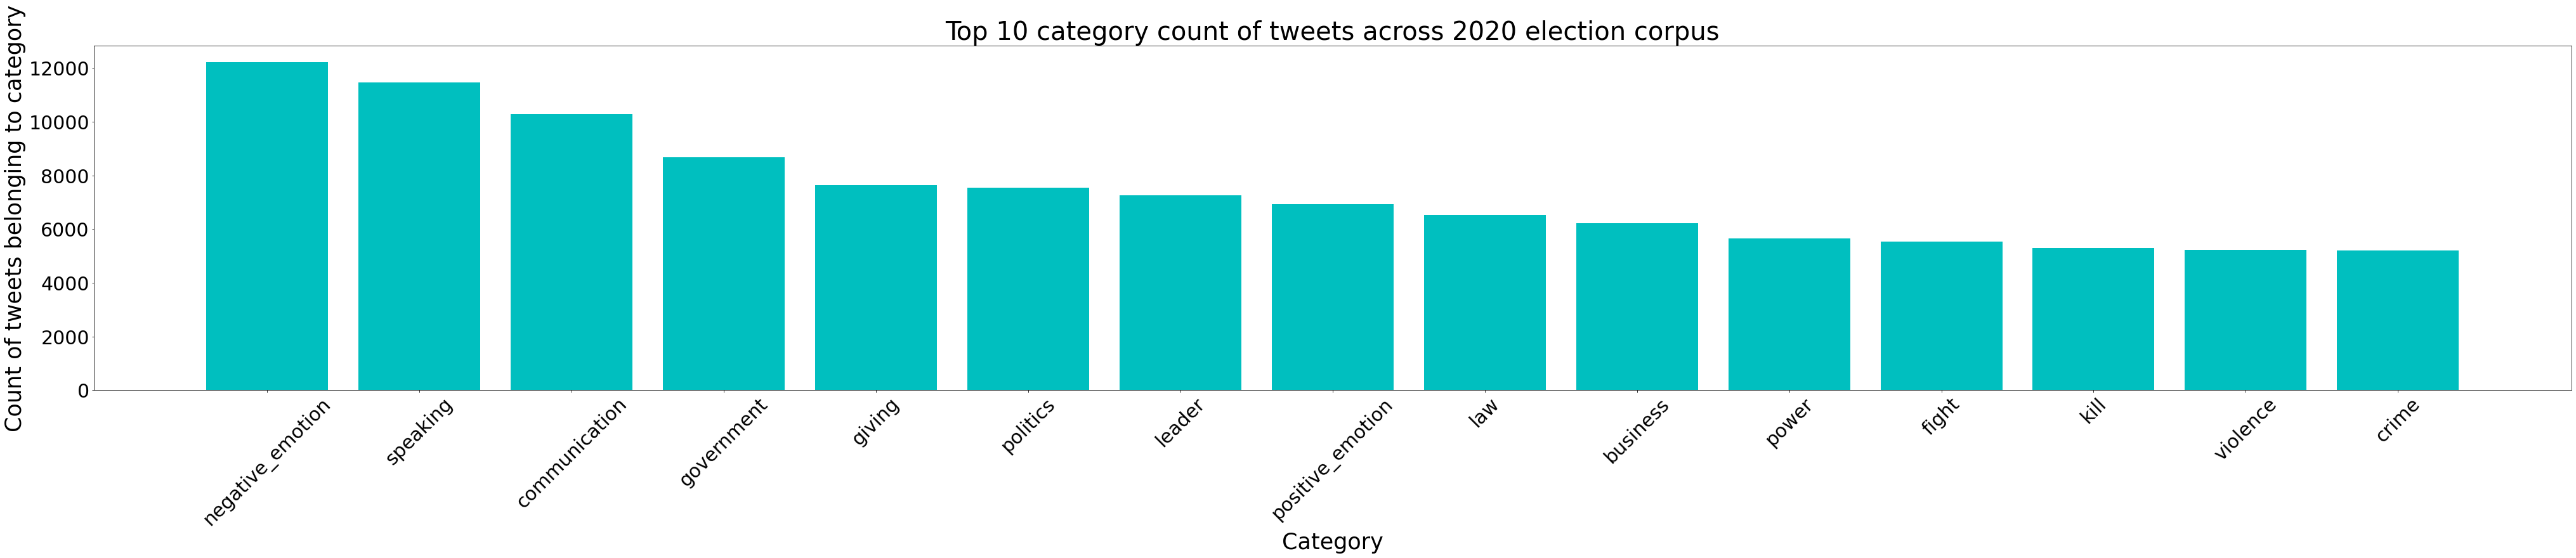

In [60]:
fig = plt.figure(figsize=(70,10))

top_10_categories = dict(sorted(catgeories_count_2020.items(), key=lambda x:x[1],reverse =True)[:15])
plt.bar(top_10_categories.keys(), top_10_categories.values(), color='c')
plt.xlabel('Category', fontsize = 35)
plt.ylabel('Count of tweets belonging to category', fontsize = 35)
plt.xticks(fontsize=30,rotation = (45))
plt.yticks(fontsize=30)
plt.title('Top 10 category count of tweets across 2020 election corpus',fontdict={'fontsize':40})


### Loading Training Data

For training our classification model, we will use a dataset with tweets labelled as hate and not hate.
link to dataset - https://www.kaggle.com/vkrahul/twitter-hate-speech?select=train_E6oV3lV.csv

In [61]:
#Loading the training dataset
training_dataset = pd.read_csv('hate_speech_training.csv')

In [62]:
#printing the shape of the dataset
print(training_dataset.shape)

(31962, 3)


#### since dataset is imbalanced, sampling data that is not hate so that number of entries for hate and no-hate data is approxinately same

In [63]:
train_data_hate = training_dataset[training_dataset.label==1]

In [64]:
train_data_no_hate = training_dataset[training_dataset.label==0].sample(frac=0.1, random_state=0)

In [65]:
training_data = pd.concat([train_data_hate,train_data_no_hate], axis =0)

In [66]:
training_data.set_index('id')

,label,tweet
id,,
14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
18,1,retweet if you agree!
24,1,@user @user lumpy says i am a . prove it lumpy.
35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
...,...,...
20020,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
14596,0,missy elliot for marc jacobs is supa dupa fly and i'm ab it
16264,0,#euro2016 sweepstake contrast


In [67]:
#printing the datatype of columns of the dataset
print(training_data.dtypes)

id        int64
label     int64
tweet    object
dtype: object


In [68]:
training_data.head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


### Cleaning Text

In [69]:
# Clean tweets in the training dataframe using clean_tweets function
training_data['tweet'] = training_data['tweet'].apply(lambda x: clean_tweets(x))

In [70]:
# Show examples of cleaned tweets
training_data.head()

,id,label,tweet
13,14,1,cnn calls michigan middle school build the wall chant tcot
14,15,1,no comment in australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins
17,18,1,retweet if you agree
23,24,1,lumpy says i am a prove it lumpy
34,35,1,its unbelievable that in the st century wed need something like this again neverump xenophobia


### Additional Cleaning - removing non ascii characters missed in the first round

In [71]:
training_data['tweet'] = training_data['tweet'].str.encode('ascii', 'ignore').str.decode('ascii')

In [72]:
training_data.head()

,id,label,tweet
13,14,1,cnn calls michigan middle school build the wall chant tcot
14,15,1,no comment in australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins
17,18,1,retweet if you agree
23,24,1,lumpy says i am a prove it lumpy
34,35,1,its unbelievable that in the st century wed need something like this again neverump xenophobia


## Removing stopwords

In [73]:
training_data['tweet'] = training_data['tweet'].apply(lambda x :' '.join([word for word in x.split() if word not in stopword]) )
training_data.head()

,id,label,tweet
13,14,1,cnn calls michigan middle school build wall chant tcot
14,15,1,comment australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins
17,18,1,retweet agree
23,24,1,lumpy says prove lumpy
34,35,1,unbelievable st century wed need something like neverump xenophobia


## Lemmetization

In [74]:
lemmatizer = WordNetLemmatizer()
training_data['tweet'] = training_data['tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
training_data.head()

,id,label,tweet
13,14,1,cnn call michigan middle school build wall chant tcot
14,15,1,comment australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins
17,18,1,retweet agree
23,24,1,lumpy say prove lumpy
34,35,1,unbelievable st century wed need something like neverump xenophobia


## Stemming

In [75]:
stemmer = PorterStemmer()
training_data['tweet'] = training_data['tweet'].apply(lambda x : ' '.join([stemmer.stem(word) for word in x.split()]))
training_data.head()

,id,label,tweet
13,14,1,cnn call michigan middl school build wall chant tcot
14,15,1,comment australia opkillingbay seashepherd helpcovedolphin thecov helpcovedolphin
17,18,1,retweet agre
23,24,1,lumpi say prove lumpi
34,35,1,unbeliev st centuri wed need someth like neverump xenophobia


## Vectorizing

In [76]:
corpus = []
for i in range(training_data.shape[0]):
    corpus.append(training_data['tweet'].iloc[i])

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [78]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
train_data_vectorized = pd.DataFrame(denselist, columns=feature_names)

In [79]:
train_data_vectorized.head()

,aaahhhh,aaberg,aah,aal,aand,ab,aba,abandon,abasel,abba,...,zimbabw,zionazi,zionism,zionist,zipaquira,zit,zone,zuma,zurich,zydeco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Training

### Model Rational

**Logistic Regression** : Logistic regression is a simple and easy to understand classification algorithm and it can be easily generalized to multiple classes.

**Naive Bayes** : Naive Bayes is another classification algorithim that can be understood easily and works very efficiently. It works by applying Bayes’ theorem which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature. This makes it exceptionally well suited for text classification.

**Random Forest** : Random Forest models are a type of ensemble models and can be quite effective for text classification since it captures the variance of several input variables at the same time and enables high number of observations to participate in the prediction.

**Gradient Boosting** : Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. These types of models have become increasingly popular due to their effectiveness at classifying complex datasets. Becuase of this we are interested in seeing how well it will work at classifying our current corpus.

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [81]:
X_train = train_data_vectorized
y_train = training_data.label

In [82]:
# Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
log_scores = cross_val_score(logistic, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# Naives Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_scores = cross_val_score(nb, X_train, y_train, cv=3)
nb_mean = nb_scores.mean()

# Random Forest
rand_clf = RandomForestClassifier()
rand_clf.fit(X_train, y_train)
rand_clf_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_clf_mean = rand_clf_scores.mean()

# Gradient Boosting
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train, y_train)
grad_clf_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_clf_mean = grad_clf_scores.mean()

#Final results
print("Logistic regression Training cross-val score: ", log_reg_mean)
print("Naive Bayes Training cross-val score: ", nb_mean)
print("Random Forest Training cross-val score: ", rand_clf_mean)
print("Gradient Boosting Training cross-val score: ", grad_clf_mean)

Logistic regression Training cross-val score:  0.851361718450326
Naive Bayes Training cross-val score:  0.8714998082086689
Random Forest Training cross-val score:  0.8565400843881857
Gradient Boosting Training cross-val score:  0.7834675872650556


## Testing on Handlabled data

In [83]:
test_2016 = election_2016[:100].text
test_2020 = election_2020[:100].text

In [84]:
hand_labels_2016 = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
hand_labels_2020 = [0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]

## Vectorizing Test Data

In [85]:
test_corpus_2016 = []
for i in range(test_2016.shape[0]):
    test_corpus_2016.append(test_2016.iloc[i])

In [86]:
test_corpus_2020 = []
for i in range(test_2020.shape[0]):
    test_corpus_2020.append(test_2020.iloc[i])

In [87]:
#vectorizer = TfidfVectorizer()
X = vectorizer.transform(test_corpus_2016)
feature_names = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
test_2016_vectorized = pd.DataFrame(denselist, columns=feature_names)

In [88]:
X = vectorizer.transform(test_corpus_2020)
feature_names = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
test_2020_vectorized = pd.DataFrame(denselist, columns=feature_names)

In [89]:
test_2016_vectorized.head()

,aaahhhh,aaberg,aah,aal,aand,ab,aba,abandon,abasel,abba,...,zimbabw,zionazi,zionism,zionist,zipaquira,zit,zone,zuma,zurich,zydeco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
test_2020_vectorized.head()

,aaahhhh,aaberg,aah,aal,aand,ab,aba,abandon,abasel,abba,...,zimbabw,zionazi,zionism,zionist,zipaquira,zit,zone,zuma,zurich,zydeco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare Models using Test Data

In [91]:
X_test_2016 = test_2016_vectorized
y_test_2016 = hand_labels_2016

In [92]:
# Logistic Regression
log_scores = cross_val_score(logistic, X_test_2016, y_test_2016, cv=3)
log_reg_mean = log_scores.mean()

# Naives Bayes
nb_scores = cross_val_score(nb, X_test_2016, y_test_2016, cv=3)
nb_mean = nb_scores.mean()

# Random Forest
rand_clf_scores = cross_val_score(rand_clf, X_test_2016, y_test_2016, cv=3)
rand_clf_mean = rand_clf_scores.mean()

# Gradient Boosting
grad_clf_scores = cross_val_score(grad_clf, X_test_2016, y_test_2016, cv=3)
grad_clf_mean = grad_clf_scores.mean()

#Final results
print("Logistic regression Training cross-val score: ", log_reg_mean)
print("Naive Bayes Training cross-val score: ", nb_mean)
print("Random Forest Training cross-val score: ", rand_clf_mean)
print("Gradient Boosting Training cross-val score: ", grad_clf_mean)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Logistic regression Training cross-val score:  0.9800950683303625
Naive Bayes Training cross-val score:  0.9800950683303625
Random Forest Training cross-val score:  0.9800950683303625
Gradient Boosting Training cross-val score:  0.9800950683303625


In [93]:
X_test_2020 = test_2020_vectorized
y_test_2020 = hand_labels_2020

In [94]:
# Logistic Regression
log_scores = cross_val_score(logistic, X_test_2020, y_test_2020, cv=3)
log_reg_mean = log_scores.mean()

# Naives Bayes
nb_scores = cross_val_score(nb, X_test_2020, y_test_2020, cv=3)
nb_mean = nb_scores.mean()

# Random Forest
rand_clf_scores = cross_val_score(rand_clf, X_test_2020, y_test_2020, cv=3)
rand_clf_mean = rand_clf_scores.mean()

# Gradient Boosting
grad_clf_scores = cross_val_score(grad_clf, X_test_2020, y_test_2020, cv=3)
grad_clf_mean = grad_clf_scores.mean()

#F inal results
print("Logistic regression Training cross-val score: ", log_reg_mean)
print("Naive Bayes Training cross-val score: ", nb_mean)
print("Random Forest Training cross-val score: ", rand_clf_mean)
print("Gradient Boosting Training cross-val score: ", grad_clf_mean)

Logistic regression Training cross-val score:  0.8401663695781343
Naive Bayes Training cross-val score:  0.8401663695781343
Random Forest Training cross-val score:  0.8401663695781343
Gradient Boosting Training cross-val score:  0.7697563874034463


**Model Decision** : All of our models perfomed similarly well on our test data except for Gradient Boosting with a slight decrease in score when applied to our 2020 test data. Due to this we will be using Naives Bayes moving forward becuase we  believe it is more well suited to classify our data than our logistic regression model and it performs more effieciently than our random forest model. 

## Classifying hate tweets with our chosen model

In [95]:
text_2016 = election_2016.text
text_2020 = election_2020.text

In [96]:
corpus_2016 = []
for i in range(text_2016.shape[0]):
    corpus_2016.append(text_2016.iloc[i])

In [97]:
corpus_2020 = []
for i in range(text_2020.shape[0]):
    corpus_2020.append(text_2020.iloc[i])

In [98]:
X_2016 = vectorizer.transform(corpus_2016)
feature_names = vectorizer.get_feature_names()
dense_2016 = X_2016.todense()
election_2016_vectorized = pd.DataFrame(dense_2016, columns=feature_names)

In [99]:
X_2020 = vectorizer.transform(corpus_2020)
feature_names = vectorizer.get_feature_names()
dense_2020 = X_2020.todense()
election_2020_vectorized = pd.DataFrame(dense_2020, columns=feature_names)

In [100]:
election_2016_vectorized.head()

,aaahhhh,aaberg,aah,aal,aand,ab,aba,abandon,abasel,abba,...,zimbabw,zionazi,zionism,zionist,zipaquira,zit,zone,zuma,zurich,zydeco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
election_2020_vectorized.head()

,aaahhhh,aaberg,aah,aal,aand,ab,aba,abandon,abasel,abba,...,zimbabw,zionazi,zionism,zionist,zipaquira,zit,zone,zuma,zurich,zydeco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
pred_2016 = nb.predict(election_2016_vectorized)

In [103]:
pred_2020 = nb.predict(election_2020_vectorized)

In [104]:
election_2016['is_hateful'] = pred_2016

In [105]:
election_2020['is_hateful'] = pred_2020

In [106]:
election_2016[['text', 'is_hateful']].head()

,text,is_hateful
0,contigu u cold spot morn f mont vista co mewx cowx,0
1,milder today snow colder air move west east tonight monday,0
2,ye info pslf info incomebas repay plan,0
3,yesterday high temp mt hysham morn low dunkirk nne mtwx,0
4,idea ancient greec help inspir america found father reach democraci,0


In [107]:
election_2020[['text', 'is_hateful']].head()

,text,is_hateful
0,today judg coney barrett would say whether voter intimid illeg clear voter intimid,1
1,sinc theoret presid im pretti sure trumpriot trumpviol,0
2,davvero pochini piazzas non li paghi non vengono,1
3,report presid consid hh secretari role previous,1
4,day dither deceiv life lost lie day clustertrump,0


### Visualizations

**Inference** : Based on these two graphs we can see that more tweets made during the 2020 election cycle were identified as hateful than tweets made during the 2016 election cycle

Text(0.5, 1.0, 'Count of nonhate and hate tweets for 2016 Election')

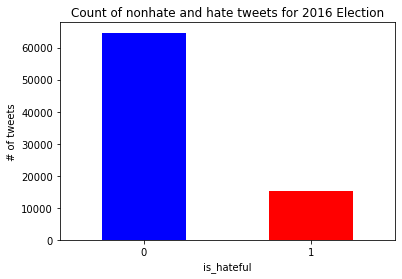

In [108]:
election_2016['is_hateful'].value_counts().plot.bar(x='is_hateful', rot=0, color=['blue', 'red'])
plt.xlabel('is_hateful') # Add x & y label, change font size
plt.ylabel('# of tweets')
plt.title('Count of nonhate and hate tweets for 2016 Election')

Text(0.5, 1.0, 'Count of nonhate and hate tweets for 2020 Election')

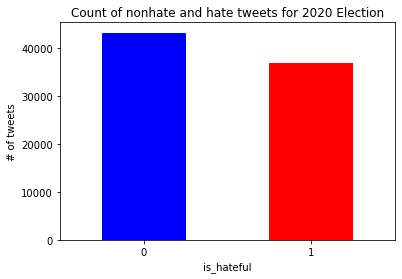

In [109]:
election_2020['is_hateful'].value_counts().plot.bar(x='is_hateful', rot=0, color=['blue', 'red'])
plt.xlabel('is_hateful')
plt.ylabel('# of tweets')
plt.title('Count of nonhate and hate tweets for 2020 Election')

### Research Question 1 : What theme of hate speech is more prevalent across the two election periods?

**Inference** : To answer the given research question, we made use of the hatebase lexicon (https://hatebase.org/) that has a compiled list of hate words across several languages. This helped us better identify commonly use hate terms in our corpus as well as the context and underlying meaning of hatewords present in our corpus. Based on the two visualizations below we see that 
for the 2016 election corpus, there was a high occurence of racial terms such as "gew" (a term that is used to refer to german gews), common hate words such as "trash" as well as certain gender offensive words such as "hoe". Similary we see that for the 2020 election period, gender offensive words such as "bitch" and "ho" were more prevalent as well as general hate words such as "trash" and "af". 
For other hate terms identified in our corpus such as "queen" and "gay", we would need to perform further analysis to understand the context of use of such terms to determine if they are hate speech.

In [110]:
#Creating a dataframe of all hateful tweets classified by the model
election_2016_hate_tweets = pd.DataFrame()
election_2016_hate_tweets = election_2016[election_2016['is_hateful']==1]

In [111]:
election_2016_hate_tweets.head()

,text,id,created_at,text_tokens,is_hateful
7,misclassif myth doesnt matter classifi independ contractor employe true,803598218319826945,2016-11-29 13:55:20,"[misclassif, myth, doesnt, matter, classifi, independ, contractor, employe, true]",1
18,cancerquiz answer fals recommend livercanc screen test lower ri,790948755080089600,2016-10-25 16:10:52,"[cancerquiz, answer, fals, recommend, livercanc, screen, test, lower, ri]",1
34,usac geologist opportun kcmo close jan appli,819589454113472515,2017-01-12 16:58:47,"[usac, geologist, opportun, kcmo, close, jan, appli]",1
43,say build resili poor help countri commun save billion year,798555216635428864,2016-11-15 15:56:14,"[say, build, resili, poor, help, countri, commun, save, billion, year]",1
51,job opportun ifl educ research analyst open share qualifi candid,719600936021139456,2016-04-11 19:00:07,"[job, opportun, ifl, educ, research, analyst, open, share, qualifi, candid]",1


In [112]:
#Creating a dataframe of all hateful tweets classified by the model
election_2020_hate_tweets = pd.DataFrame()
election_2020_hate_tweets = election_2020[election_2020['is_hateful']==1]

In [113]:
#Loading the hatebase vocabulary to find hatewords in our corpus
hate_speech_data = pd.read_csv('hatebase_vocab.csv')
hate_speech_data.head()

,Unnamed: 0,vocabulary_id,term,hateful_meaning,nonhateful_meaning,is_unambiguous,is_unambiguous_in,average_offensiveness,language,plural_of,...,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class,number_of_sightings,number_of_sightings_this_year,number_of_sightings_this_month,created_on,updated_on
0,0,vTDeD7YR2,Paedo,Often deployed against Muslims on social media to imply that they engage in sexual abuse of children,NaN,False,NaN,100.0,eng,NaN,...,True,False,False,False,False,0,0,0,1/9/2021 22:37,1/11/2021 13:02
1,1,ebHNRfJax,Hodgie,Potentially degrades [1] traditional-looking Muslims and [2] brown-skinned people,"Slang offshoot of term ""Hajji"" (that means a Muslim who has gone to Hajj -pilgrimage)",False,NaN,75.0,eng,NaN,...,True,False,False,False,False,0,0,0,1/9/2021 2:19,1/11/2021 12:58
2,2,cdtmegdan,sand ape,Variant of 'sand nigger' in relation to inhabitants of desert regions or Arabs / Muslims in general,NaN,False,NaN,100.0,eng,NaN,...,True,False,False,False,False,0,0,0,1/9/2021 22:39,1/9/2021 22:39
3,3,TXTXsPJiF,islamization,"[1] Muslim conspiracy to take over the West, extremely degrading",NaN,False,NaN,50.0,eng,NaN,...,True,False,False,False,False,0,0,0,1/9/2021 22:31,1/9/2021 22:31
4,4,yUXynqvWQ,porki,"A person from South Asia or the Middle East, particularly a person from Pakistan.",NaN,False,NaN,75.0,eng,NaN,...,True,False,False,False,False,0,0,0,1/9/2021 22:23,1/9/2021 22:23


In [114]:
#Creating a function to find exact hate words from the hatebase lexicon that are present in our corpus
def hate_speech_tagging(classified_hate_tweets):
    hate_words_dict = defaultdict(int)
    for words in hate_speech_data['term']:
        for tweet in classified_hate_tweets:
            words_match = re.findall("\\b"+words+"\\b",tweet)
            if len(words_match):
                hate_words_dict[words]+=1
    return hate_words_dict
            

In [115]:
hate_words_dict_2016 = hate_speech_tagging(election_2016['text'])

In [116]:
hate_words_dict_2020 = hate_speech_tagging(election_2020['text'])

Text(0.5, 1.0, 'Top 15 hate words count across 2016 election corpus')

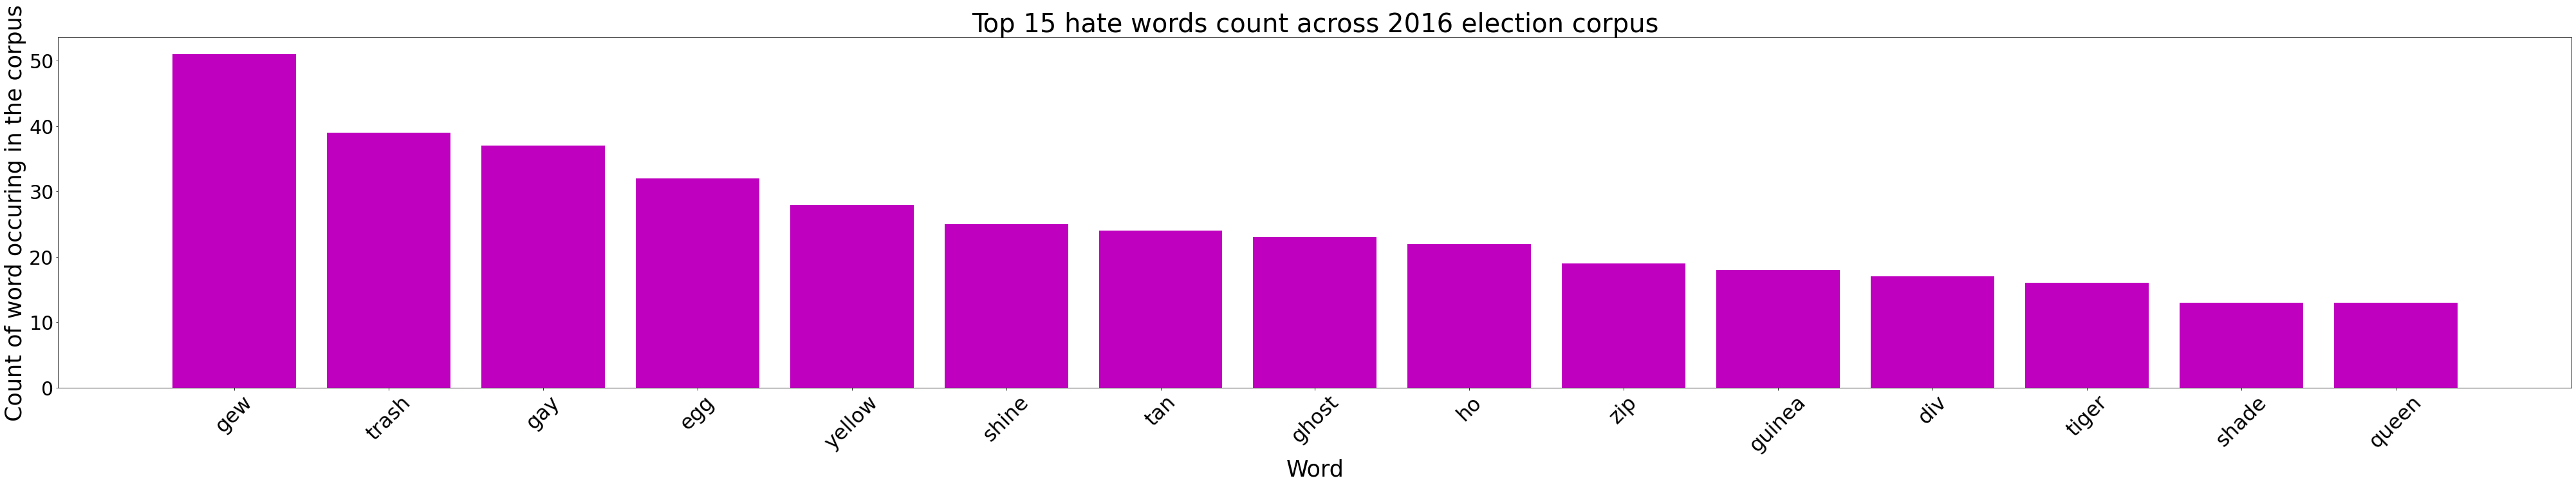

In [117]:
#Ploting the frequency of occurence of hatewords across the tweets classified as hateful in the 2016 election corpus
fig = plt.figure(figsize=(70,10))

top_10_hate_speech_words_2016 = dict(sorted(hate_words_dict_2016.items(), key=lambda x:x[1],reverse =True)[:15])
plt.bar(top_10_hate_speech_words_2016.keys(), top_10_hate_speech_words_2016.values(), color='m')
plt.xlabel('Word', fontsize = 35)
plt.ylabel('Count of word occuring in the corpus', fontsize = 35)
plt.xticks(fontsize=32,rotation = (45))
plt.yticks(fontsize=30)
plt.title('Top 15 hate words count across 2016 election corpus',fontdict={'fontsize':40})

Text(0.5, 1.0, 'Top 15 hate words count across 2020 election corpus')

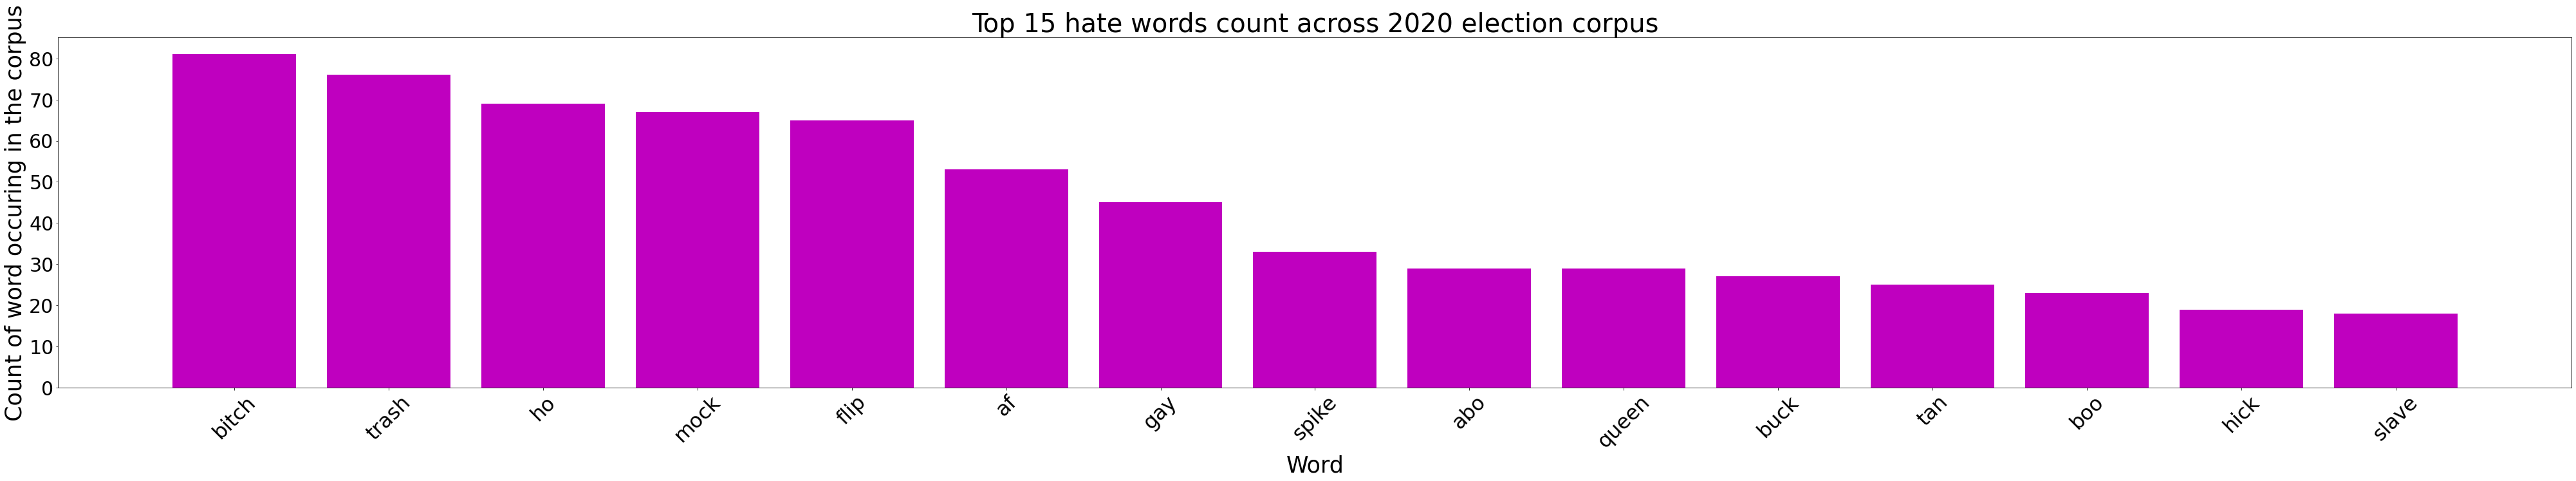

In [118]:
#Ploting the frequency of occurence of hatewords across the tweets classified as hateful in  the 2020 election corpus

fig = plt.figure(figsize=(70,10))

top_10_hate_speech_words_2020 = dict(sorted(hate_words_dict_2020.items(), key=lambda x:x[1],reverse =True)[:15])
plt.bar(top_10_hate_speech_words_2020.keys(), top_10_hate_speech_words_2020.values(), color='m')
plt.xlabel('Word', fontsize = 35)
plt.ylabel('Count of word occuring in the corpus', fontsize = 35)
plt.xticks(fontsize=32,rotation = (45))
plt.yticks(fontsize=30)
plt.title('Top 15 hate words count across 2020 election corpus',fontdict={'fontsize':40})

## Research Question 2: How did hate speech spread change from 2016 to 2020 elections

In [119]:
election_2016_hateful = election_2016[election_2016["is_hateful"]==1]
election_2020_hateful = election_2020[election_2020["is_hateful"]==1]

In [120]:
election_2016_hateful['Month'] = list(pd.DatetimeIndex(election_2016_hateful["created_at"]).month)
election_2020_hateful['Month'] = list(pd.DatetimeIndex(election_2020_hateful["created_at"]).month)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
election_2016_trend = election_2016_hateful.groupby(election_2016_hateful["created_at"].dt.strftime('%B'))['is_hateful'].count().sort_values()

In [156]:
election_2020_trend = election_2020_hateful.groupby(election_2020_hateful["created_at"].dt.strftime('%B'))['is_hateful'].count().sort_values()

In [165]:
y_2016 = list(election_2016_trend)
y_2020 = list(election_2020_trend)

In [173]:
trend_2016 = pd.DataFrame(election_2016_trend)
trend_2020 = pd.DataFrame(election_2020_trend)

In [176]:
trend_2016['Month'] = [2,4,5,3,9,8,6,7,10,1,12,11]
trend_2020['Month'] = [9,5,2,1,4,3,6,8,7,11,10,12]

In [178]:
trend_2016.sort_values('Month',inplace=True)
trend_2020.sort_values('Month',inplace=True)

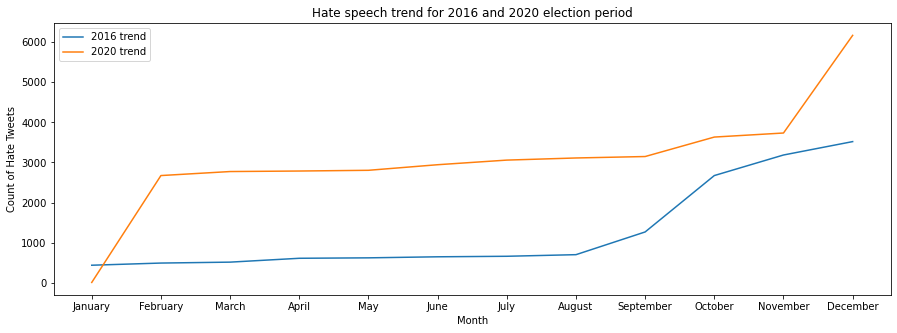

In [180]:
fig = plt.figure(figsize=(15,5))
plt.plot(trend_2016.index,y_2016, label = "2016 trend")
plt.plot(trend_2020.index,y_2020, label = "2020 trend")
plt.xlabel("Month")
plt.ylabel("Count of Hate Tweets")
plt.title("Hate speech trend for 2016 and 2020 election period")
plt.legend()
plt.show()

## Inference: 
From the graph we can see that hate speech rose much more significantly on 2020 as compared to 2016 election cycle. There could be several reasons for this such as increased social media usage, rising polarized content etc. Further analysis will be needed to establish concrete reasons.

## Limitations:
1. One limitation was the lack of labeled hate tweet data sources that were specific to the 2016 and 2020 election cycle. As a workaround, we trained our model on a general political dataset and used hand coded labels to determine efficiency of the model on our election data.

2. More extensive research and tools will be needed to identify the exact themes behind the kind of hate speech that is being spread. It is difficult to identify the context of the hate content eg. race, gender, sexuality etc without taking a NLP or deep learning approach.

3. Since Twitter does not have sensitive data such as location readily available, we cannot use that in our analysis to determine whether certain geographical regions are spreading more hate tweets. (eg. red states vs blue states)
    
    
## Ethical Considerations
Ethical considerations when dealing with Twitter data means that we need to ensure that user identity is kept hidden and no personal information (if available) is used without appropriate permissions.


## Future Work
1. Research to find out why hate speech tweets were higher during 2020 election cycle as compared to 2016 election cycle
2. Use deep learning approach to identify widely spread categories of hate speech 
3. Analyze how much hate speech is being spread by verified Twitter accounts (eg. politicians) and their followers(using retweet count data). 